In [1]:
import pandas as pd
df = pd.read_csv('thesaurus_words_with_meaning.csv')

In [2]:
words = df['word_with_meaning']

In [3]:
from langchain_openai import OpenAIEmbeddings
embeddings_model = OpenAIEmbeddings()
word_embeddings = embeddings_model.embed_documents(words)


In [4]:
import numpy
word_embeddings = numpy.array(word_embeddings)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test= train_test_split(word_embeddings, test_size=0.2, random_state=42)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import seaborn as sns

In [7]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = X_test.shape[1:]
latent_dim = 16
autoencoder = Autoencoder(latent_dim, shape)

In [8]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [9]:
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/10
1918/1918 [==============================] - 2s 993us/step - loss: 0.0073 - val_loss: 5.7446e-04
Epoch 2/10
1918/1918 [==============================] - 2s 1ms/step - loss: 5.6204e-04 - val_loss: 5.5528e-04
Epoch 3/10
1918/1918 [==============================] - 2s 883us/step - loss: 5.5271e-04 - val_loss: 5.5107e-04
Epoch 4/10
1918/1918 [==============================] - 2s 907us/step - loss: 5.5019e-04 - val_loss: 5.4964e-04
Epoch 5/10
1918/1918 [==============================] - 2s 967us/step - loss: 5.4926e-04 - val_loss: 5.4901e-04
Epoch 6/10
1918/1918 [==============================] - 2s 903us/step - loss: 5.4876e-04 - val_loss: 5.4857e-04
Epoch 7/10
1918/1918 [==============================] - 2s 984us/step - loss: 5.4833e-04 - val_loss: 5.4814e-04
Epoch 8/10
1918/1918 [==============================] - 2s 997us/step - loss: 5.4784e-04 - val_loss: 5.4753e-04
Epoch 9/10
1918/1918 [==============================] - 2s 888us/step - loss: 5.4707e-04 - val_loss: 5.4661e-0

In [10]:
new_embeddings = autoencoder.encoder(word_embeddings).numpy()

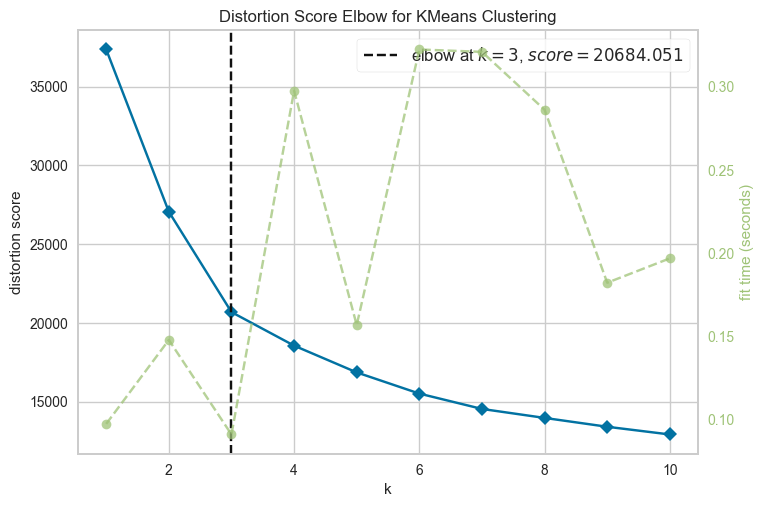

In [11]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,11))
visualizer.fit(new_embeddings)
_ = visualizer.show()

In [12]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(new_embeddings)

KMeans(n_clusters=6, random_state=0)

In [13]:
def plot_pca_clusters(X_PCA, labels, colors=None, names=None):
    """
    Plots clusters based on PCA results.
    
    Parameters:
    - X_PCA: PCA results, expecting an array with at least two dimensions.
    - labels: Cluster labels for each point in X_PCA.
    - colors: Optional dictionary mapping labels to colors.
    - names: Optional dictionary mapping labels to cluster names.
    """
    # Default colors and names if none provided
    default_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple']
    default_names = ['Cluster {}'.format(i+1) for i in range(len(set(labels)))]
    
    # Use default if not specified
    if colors is None:
        colors = {i: default_colors[i % len(default_colors)] for i in range(len(set(labels)))}
    if names is None:
        names = {i: default_names[i] for i in range(len(set(labels)))}
    
    # Create DataFrame
    dataframe = pd.DataFrame({'x': X_PCA[:, 0], 'y': X_PCA[:, 1], 'label': labels}) 
    groups = dataframe.groupby('label')

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8)) 
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors.get(name, 'grey'), label=names.get(name, 'Unknown'), mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.tick_params(axis='y', which='both', left=False, top=False, labelleft=False)
    
    ax.legend()
    plt.show()

In [14]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(new_embeddings)
X_PCA = pca.transform(new_embeddings)
X_PCA.shape

(76710, 2)

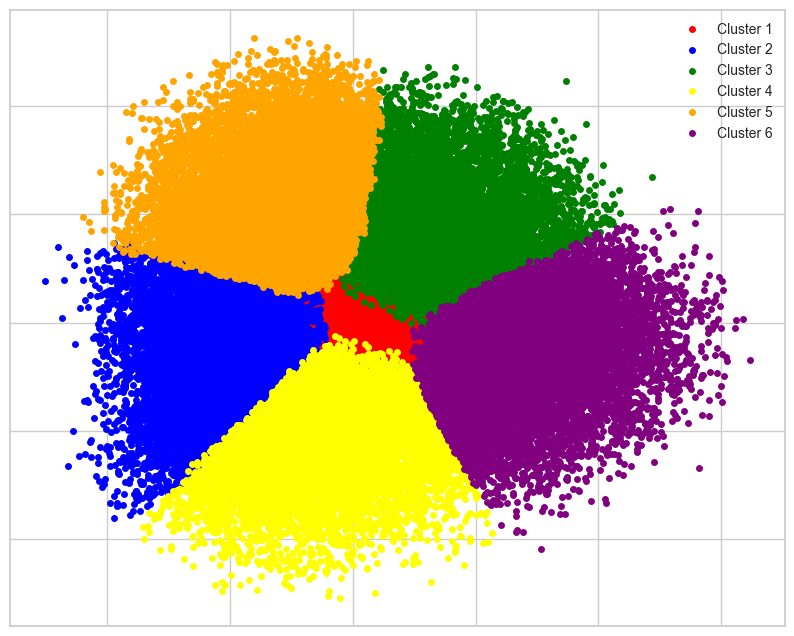

In [15]:
plot_pca_clusters(X_PCA, kmeans.labels_)

In [16]:
def visualize_class_distribution_in_clusters(df, true_label_col, predicted_label_col):
    distribution = df.groupby([predicted_label_col, true_label_col]).size().unstack(fill_value=0)
    percentage_distribution = distribution.div(distribution.sum(axis=1), axis='rows') * 100
    plt.figure(figsize=(12, 8))
    sns.heatmap(percentage_distribution, annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title('Percentage of Real Classes in Each Cluster')
    plt.ylabel(predicted_label_col)
    plt.xlabel(true_label_col)
    plt.show()

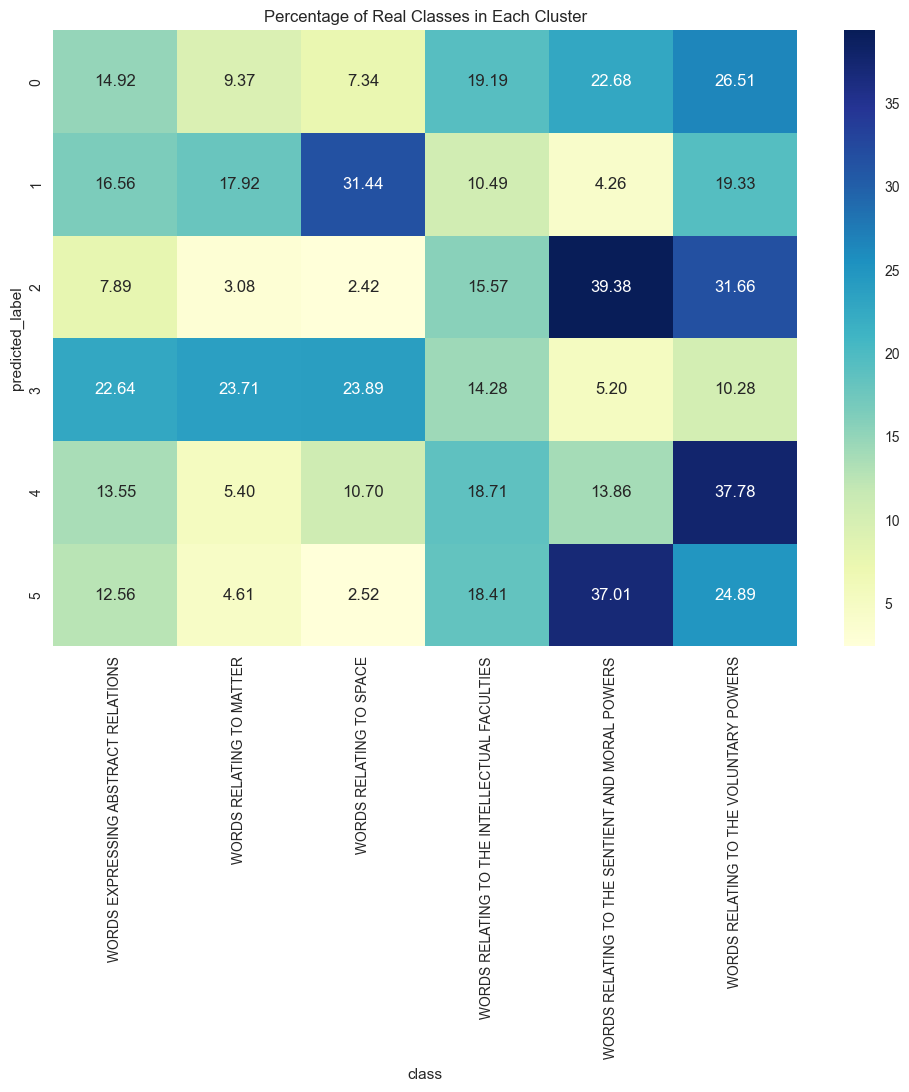

In [17]:
df['predicted_label'] = kmeans.labels_
visualize_class_distribution_in_clusters(df, 'class', 'predicted_label')

In [ ]:
from sklearn.cluster._hdbscan import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=2000)
cluster_labels = clusterer.fit_predict(new_embeddings)

In [ ]:
cluster_labels

In [ ]:
plot_pca_clusters(X_PCA, cluster_labels)

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(word_embeddings, kmeans.labels_)
print(f"The average silhouette score for {6} clusters is: {silhouette_avg}")

The visualization indicates enhanced cluster distinction, suggesting effective separation. The confusion matrix reveals predominant classification of points into original classes within some clusters, yet ambiguity persists, hinting at issues in thesaurus construction—specifically, overlapping synonymous words may hinder optimal separation. This suggests the chosen method for word separation in the thesaurus might not be the most effective.


We're transitioning to the classification phase of this project. Our approach involves leveraging embeddings to train some classifiers that are categorizing words into thesaurus classes. The process begins with encoding the classes, a preparatory step not mandatory for scikit-learn models but essential for our subsequent neural network training. Following encoding, we'll partition the dataset into training and testing sets to facilitate model evaluation and validation.